### Same task as in `AutoencoderMNIST.ipynb`, this time implemented in lightning

In [2]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl

c:\Users\aleks\anaconda3\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [3]:
dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = transforms.ToTensor()) #


train_set, test_set, valid_set =\
                torch.utils.data.random_split(dataset, (int(0.7*len(dataset)), int(0.15*len(dataset)), int(0.15*len(dataset))))

train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = 32)
validation_loader = torch.utils.data.DataLoader(dataset = valid_set, batch_size = 32)
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = 32)

In [86]:
x, y=  next(iter(train_loader))
x.reshape(-1, 28*28).size()
y

tensor([2, 6, 1, 9, 3, 0, 4, 2, 9, 6, 8, 8, 6, 2, 7, 5, 4, 3, 1, 2, 1, 7, 2, 0,
        4, 6, 0, 5, 3, 3, 8, 3])

In [33]:
Nfeatures = 28*28 #size of the encoder input layer
Layers=[128,64,36,18] #sizes of inner layers
NTargets=10 #size of the encoder output layer

In [101]:
class MNIST_AE(pl.LightningModule): 

### Model ###
    def __init__(self, Nfeatures, Layers, Ntargets):
        super(MNIST_AE, self).__init__() # TODO: if not "cannot assign module before Module.__init__() call"
        # Initialize layers
        self.encoderIn = torch.nn.Linear(Nfeatures, Layers[0]) #first layer 28*28 -> 128
        self.encoderl1 = torch.nn.Linear(Layers[0], Layers[1])
        self.encoderl2 = torch.nn.Linear(Layers[1], Layers[2])
        self.encoderl3 = torch.nn.Linear(Layers[2], Layers[3])
        self.encoderOut = torch.nn.Linear(Layers[3], Ntargets)

        self.decoderIn = torch.nn.Linear(Ntargets, Layers[3]) #f
        self.decoderl1 = torch.nn.Linear(Layers[3], Layers[2])
        self.decoderl2 = torch.nn.Linear(Layers[2], Layers[1])
        self.decoderl3 = torch.nn.Linear(Layers[1], Layers[0])
        self.decoderOut = torch.nn.Linear(Layers[0], Nfeatures)
        # TODO: better place to define mse_loss
        self.mse_loss = torch.nn.MSELoss(reduction = 'mean')
        self.validation_step_outputs = []


    def forward(self, x):
        x = torch.relu(self.encoderIn(x))
        x = torch.relu(self.encoderl1(x))
        x = torch.relu(self.encoderl2(x))
        x = torch.relu(self.encoderl3(x))
        x = self.encoderOut(x)
        x = torch.relu(self.decoderIn(x))
        x = torch.relu(self.decoderl1(x))
        x = torch.relu(self.decoderl2(x))
        x = torch.relu(self.decoderl3(x))
        x = self.decoderOut(x)
        return x

### The Optimizer ### 
    def configure_optimizers(self):
        #optimizer = torch.optim.Adam(self.parameters(), lr=0.05)#l_rate) # TODO: should be a parameter
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-5)#l_rate) # TODO: should be a parameter
        return optimizer

### Training ### 
    def training_step(self, batch, batch_idx):
        images, label = batch
        images = images.reshape(-1, 28*28)
        # Evaluate physical model using data scaling
        logits = self.forward(images)
        # Evaluate loss comparing to the kinetic heat flux in y
        loss = self.mse_loss(logits, images)
        # Add logging
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}

### Validation ### 
    def validation_step(self, batch, batch_idx):
        images, label = batch
        images = images.reshape(-1, 28*28)
        # Evaluate physical model using data scaling
        logits = self.forward(images)
        # Evaluate loss comparing to the kinetic heat flux in y
        loss = self.mse_loss(logits, images)
        self.validation_step_outputs.append(loss)
        return {'val_loss': loss}

    # Define validation epoch end
    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self.validation_step_outputs).mean()
        self.log("validation_epoch_average", avg_loss)
        self.validation_step_outputs.clear()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

In [102]:
model=MNIST_AE(Nfeatures, Layers, NTargets)

In [103]:
len(model.state_dict())

20

In [104]:
pl.utilities.model_summary.ModelSummary(model,max_depth=3)

   | Name       | Type    | Params
----------------------------------------
0  | encoderIn  | Linear  | 100 K 
1  | encoderl1  | Linear  | 8.3 K 
2  | encoderl2  | Linear  | 2.3 K 
3  | encoderl3  | Linear  | 666   
4  | encoderOut | Linear  | 190   
5  | decoderIn  | Linear  | 198   
6  | decoderl1  | Linear  | 684   
7  | decoderl2  | Linear  | 2.4 K 
8  | decoderl3  | Linear  | 8.3 K 
9  | decoderOut | Linear  | 101 K 
10 | mse_loss   | MSELoss | 0     
----------------------------------------
224 K     Trainable params
0         Non-trainable params
224 K     Total params
0.899     Total estimated model params size (MB)

In [105]:
for name in model.state_dict():
    print(name)

encoderIn.weight
encoderIn.bias
encoderl1.weight
encoderl1.bias
encoderl2.weight
encoderl2.bias
encoderl3.weight
encoderl3.bias
encoderOut.weight
encoderOut.bias
decoderIn.weight
decoderIn.bias
decoderl1.weight
decoderl1.bias
decoderl2.weight
decoderl2.bias
decoderl3.weight
decoderl3.bias
decoderOut.weight
decoderOut.bias


In [106]:
trainer = pl.Trainer(max_epochs = 5)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [107]:
trainer.fit(model, train_loader, validation_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name       | Type    | Params
----------------------------------------
0  | encoderIn  | Linear  | 100 K 
1  | encoderl1  | Linear  | 8.3 K 
2  | encoderl2  | Linear  | 2.3 K 
3  | encoderl3  | Linear  | 666   
4  | encoderOut | Linear  | 190   
5  | decoderIn  | Linear  | 198   
6  | decoderl1  | Linear  | 684   
7  | decoderl2  | Linear  | 2.4 K 
8  | decoderl3  | Linear  | 8.3 K 
9  | decoderOut | Linear  | 101 K 
10 | mse_loss   | MSELoss | 0     
----------------------------------------
224 K     Trainable params
0         Non-trainable params
224 K     Total params
0.899     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\aleks\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


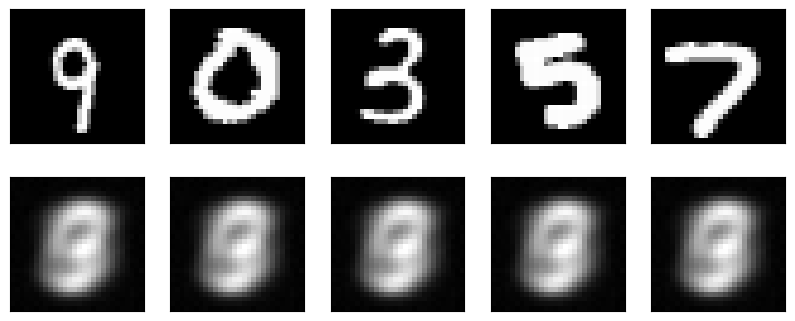

In [111]:
def plot_digits(*args): #just plotting the result

    n = min([x.shape[0] for x in args]) #n=5
    
    plt.figure(figsize=(2*n, 2*len(args))) #10 na 4
    for j in range(n): #j [1,2,3,4,5]
        for i in range(len(args)): #i [1,2]
            img=args[i][j].reshape(-1,28,28).detach().numpy()
            ax = plt.subplot(len(args), n, i*n + j + 1) #arguments: nrows, ncols, index
            plt.imshow(img[0])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

xbatch, ybatch =next(iter(test_loader))
xbatch=xbatch.reshape(-1,28*28)
a=[model(x) for x in xbatch[:5]]
a=torch.stack(a, dim=0)

plot_digits(xbatch[:5], a)

In [114]:
%load_ext tensorboard

ModuleNotFoundError: No module named 'tensorboard'